# Dutch Corpora

Before running this notebook, install the `tempo-embeddings` package in your local Git repository:

```bash
pip install .
```

See [README.dev.md](../README.dev.md) for more details.

The following command does the same, checking out the repository and installing the current version:

In [40]:
# This can also refer to a specific version or branch

%pip install --upgrade pip  # Required for properly resolving dependencies
%pip uninstall -y tempo_embeddings  # Remove existing installation
%pip install --upgrade git+https://github.com/Semantics-of-Sustainability/tempo-embeddings.git


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Found existing installation: tempo-embeddings 0.0.1
Uninstalling tempo-embeddings-0.0.1:
  Successfully uninstalled tempo-embeddings-0.0.1
Note: you may need to restart the kernel to use updated packages.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to

In [1]:
%load_ext autoreload

In [2]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

## Load Model

In [3]:
%autoreload now

LAYER = 9

from tempo_embeddings.embeddings.model import (
    RobertaModelWrapper,
    TransformerModelWrapper,
    XModModelWrapper,
    SentenceTransformerModelWrapper,
)

kwargs = {"accelerate": True}

### RoBERTa Models
# MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled"
# model_class = RobertaModelWrapper

### XMod Models
# MODEL_NAME = "facebook/xmod-base"
# kwargs["default_language"] = "nl_XX"
# model_class = XModModelWrapper

### BERT Models
# MODEL_NAME = "GroNLP/bert-base-dutch-cased"
# MODEL_NAME = "xlm-roberta-base"
# MODEL_NAME = "xlm-mlm-100-1280"
# model_class = TransformerModelWrapper

### Sentence Transformers
MODEL_NAME = "NetherlandsForensicInstitute/robbert-2022-dutch-sentence-transformers"
# MODEL_NAME = "textgain/allnli-GroNLP-bert-base-dutch-cased"
model_class = SentenceTransformerModelWrapper

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDe

In [4]:
model = model_class.from_pretrained(MODEL_NAME, layer=LAYER, **kwargs)
model

## Load Data

The data needs to be downloaded and provided in the path configured in the next cell.

NOTE: You have to manually adapt the `DATA_DIR` below.

In [5]:
%autoreload now

import operator
from functools import reduce
from pathlib import Path
from tqdm import tqdm
from tempo_embeddings.text.corpus import Corpus

In [6]:
WINDOW_SIZE = 200

RANDOM_SAMPLE_ANP = 0
RANDOM_SAMPLE_STATEN_GENERAAL = 200

STATEN_GENERAAL_BLACKLIST = ["1987"]

FILTER_TERMS = ["duurzaam"]  # Search term(s) for filtering the corpus

In [7]:
### NOTE: Adapt the `DATA_DIR` below manually!
### For a shared Google Drive, create a shortcut into your own Google Drive
### See https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab

LOCAL_PATHS: list[Path] = [
    Path.home() / "Documents" / "SemanticsOfSustainability" / "data" / "Joris",
    Path("/home/cschnober/data/"),  # Snellius
]

if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

    DATA_DIR = Path("/content/drive/MyDrive/Data/")
else:
    try:
        DATA_DIR = next(path for path in LOCAL_PATHS if path.is_dir())
    except StopIteration as e:
        raise DirectoryNotFoundError(f"Data directory not found.") from e

assert DATA_DIR.is_dir(), f"Data dir '{DATA_DIR}' not found."

### ANP

In [8]:
ANP_DIR = DATA_DIR / "ANP" / "CleanFiles_perYear"
assert RANDOM_SAMPLE_ANP == 0 or ANP_DIR.is_dir()

In [9]:
import random

random.seed(0)

files = random.sample(list(ANP_DIR.glob("ANP_????.csv.gz")), k=RANDOM_SAMPLE_ANP)
files[:10]

[]

In [10]:
anp_corpus = (
    reduce(
        operator.add,
        (
            Corpus.from_csv_file(
                path,
                filter_terms=FILTER_TERMS,
                text_columns=["content"],
                encoding="iso8859_15",
                compression="gzip",
                delimiter=";",
                window_size=WINDOW_SIZE,
            )
            for path in tqdm(files, unit="file")
        ),
    )
    if files
    else Corpus()
)

len(anp_corpus)

0

### Staten Generaal

In [11]:
STATEN_GENERAAL_DIR = DATA_DIR / "StatenGeneraal"

assert RANDOM_SAMPLE_STATEN_GENERAAL == 0 or STATEN_GENERAAL_DIR.is_dir()

In [12]:
glob195x = "StatenGeneraal_19[0-9]?.csv.gz"  # Pattern for files from 1950-1999
glob20xx = "StatenGeneraal_2???.csv.gz"  # Pattern for files from 2000

files_195x = list(STATEN_GENERAAL_DIR.glob(glob195x))
files_20xx = list(STATEN_GENERAAL_DIR.glob(glob20xx))

files = [
    file
    # Merge files from patterns
    for file in files_20xx + files_195x
    # Remove blacklisted files:
    for blacklisted in STATEN_GENERAAL_BLACKLIST
    if blacklisted not in file.name
]

if RANDOM_SAMPLE_STATEN_GENERAAL and RANDOM_SAMPLE_STATEN_GENERAAL < len(files):
    files = random.sample(files, k=RANDOM_SAMPLE_STATEN_GENERAAL)

sorted(files)

[PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1900.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1901.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1902.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1903.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1904.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1905.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1906.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal

In [13]:
%autoreload now

import csv

csv.field_size_limit(100000000)

sg_corpus = (
    reduce(
        operator.add,
        (
            Corpus.from_csv_file(
                path,
                filter_terms=FILTER_TERMS,
                text_columns=["Content"],
                encoding="utf-8",
                compression="gzip",
                delimiter=";",
                window_size=WINDOW_SIZE,
            )
            for path in tqdm(files, unit="file")
        ),
    )
    if files
    else Corpus()
)

len(sg_corpus)

  0%|          | 0/118 [00:00<?, ?file/s]

100%|██████████| 118/118 [00:59<00:00,  1.99file/s]


26925

In [14]:
for p in sg_corpus.passages[:20]:
    print(len(p), p)

200 Passage('geweest van een duurzaam proces van versterking van de positie van de provincie. Het wetsvoorstel wil daarin dan ook geen wijziging brengen. Dat lijkt ons op dit ogenblik een goed uitgangspunt. Het is', {'': '109', 'RecId': 'h-ek-20022003-421-456', 'chamber': 'EersteKamer', 'date': '2003-01-14', 'speakers': 'De heer Witteveen PvdA|Mevrouw Meindertsma PvdA|De heer Platvoet GroenLinks|De heer Dölle CDA|De heer Witteveen PvdA|De heer Dölle CDA|De heer Holdijk SGP|De heer Platvoet GroenLinks|De heer Holdijk SGP|De heer Platvoet GroenLinks|De heer Holdijk SGP|De heer Bierman OSF|De heer Terlouw D66|De heer Bierman OSF|De heer Terlouw D66|De heer Platvoet GroenLinks|De heer Terlouw D66|De heer Dölle CDA|De heer Terlouw D66|De heer Luijten VVD|Minister Remkes|De heer Witteveen PvdA|Minister Remkes|De heer Witteveen PvdA|Minister Remkes|De heer Platvoet GroenLinks|Minister Remkes|Mevrouw Meindertsma PvdA|Minister Remkes|De heer Terlouw D66|Minister Remkes|De heer Platvoet GroenLin

### Merge

In [15]:
corpus = anp_corpus + sg_corpus
len(corpus)

26925

## Compute Vectorizer

In [16]:
vectorizer = corpus.tfidf_vectorizer()
vectorizer

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(preprocessor=<function AbstractCorpus.tfidf_vectorizer.<locals>.<lambda> at 0x32e3cb380>,
                tokenizer=<function AbstractCorpus.tfidf_vectorizer.<locals>.tokenizer at 0x32e3cb7e0>)

## Compute Embeddings

In [17]:
%autoreload now

from tempo_embeddings.embeddings.model import EmbeddingsMethod

model.batch_size = 128
model.embeddings_method = EmbeddingsMethod.MEAN

corpus.embeddings = model.compute_embeddings(corpus)

Embeddings:   0%|          | 0/211 [00:00<?, ?batch/s]

Embeddings: 100%|██████████| 211/211 [02:36<00:00,  1.35batch/s]


UMAP( verbose=True)
Wed Nov  1 11:50:53 2023 Construct fuzzy simplicial set
Wed Nov  1 11:50:53 2023 Finding Nearest Neighbors
Wed Nov  1 11:50:53 2023 Building RP forest with 13 trees
Wed Nov  1 11:50:54 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	 7  /  15
	Stopping threshold met -- exiting after 7 iterations
Wed Nov  1 11:51:03 2023 Finished Nearest Neighbor Search
Wed Nov  1 11:51:04 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:03]


Wed Nov  1 11:51:09 2023 Finished embedding


## Read Stopwords

In [18]:
!wget --continue https://raw.githubusercontent.com/Semantics-of-Sustainability/tempo-embeddings/main/tempo_embeddings/data/stopwords-filter-nl.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
--2023-11-01 11:51:09--  https://raw.githubusercontent.com/Semantics-of-Sustainability/tempo-embeddings/main/tempo_embeddings/data/stopwords-filter-nl.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [19]:
stopwords_file = Path("stopwords-filter-nl.txt")

with open(stopwords_file.absolute(), "rt") as f:
    stopwords = set(f.read().splitlines())

stopwords.update(
    {"wij", "we", "moeten", "heer", "mevrouw", "minister", "voorzitter", "gaat", "wel"}
)

## Cluster

In [20]:
%autoreload now

# Arguments: min_cluster_size=10, cluster_selection_epsilon=0.1, ...
# See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html for full list

# e.g. min_samples=10, cluster_selection_epsilon=0.2, cluster_selection_method="leaf"

clusters = corpus.cluster(min_cluster_size=10, cluster_selection_epsilon=0.1)
print(clusters)

[Subcorpus(24, [0, 1806, 5929, 6586, 6587, 6588, 6589, 6590, 6591, 6592]), Subcorpus(39, [1, 718, 2107, 6046, 6561, 6564, 6565, 10642, 11773, 13424]), Subcorpus(47, [2, 3, 4, 9, 10, 11, 12, 14, 15, 16]), Subcorpus(-1, [5, 13, 42, 47, 48, 49, 57, 63, 73, 98]), Subcorpus(46, [6, 7, 8, 26, 65, 68, 95, 96, 97, 108]), Subcorpus(9, [32, 666, 1005, 1718, 1720, 2362, 2440, 3068, 3069, 3419]), Subcorpus(14, [36, 75, 80, 455, 863, 864, 931, 932, 1046, 1047]), Subcorpus(32, [51, 93, 1219, 1355, 3186, 3238, 3807, 3884, 4393, 4580]), Subcorpus(33, [54, 59, 64, 138, 144, 155, 319, 333, 379, 392]), Subcorpus(37, [70, 665, 677, 804, 805, 833, 4036, 4077, 4746, 4757]), Subcorpus(12, [76, 77, 6183, 7246, 7247, 14531, 19852, 20203, 20205, 21412]), Subcorpus(30, [207, 467, 509, 528, 737, 756, 1103, 1823, 1877, 1879]), Subcorpus(25, [224, 861, 1249, 6059, 7267, 8449, 10743, 10744, 13972, 14087]), Subcorpus(4, [280, 282, 288, 289, 2075, 2076, 2108, 2112, 2113, 2114]), Subcorpus(26, [285, 330, 331, 588, 668,

In [21]:
for cluster in clusters:
    cluster.set_topic_label(
        vectorizer=vectorizer, exclude_words=stopwords | set(FILTER_TERMS), n=5
    )
    print(cluster)

Subcorpus('openbare; begrip; orde; duurzaamheid; discutabel', [0, 1806, 5929, 6586, 6587, 6588, 6589, 6590, 6591, 6592])
Subcorpus('geleide; ten; storten; waterstaat; inzake', [1, 718, 2107, 6046, 6561, 6564, 6565, 10642, 11773, 13424])
Subcorpus('duurzaamheid; vraag; bouwen; kabinet; maken', [2, 3, 4, 9, 10, 11, 12, 14, 15, 16])
Subcorpus('Outliers', [5, 13, 42, 47, 48, 49, 57, 63, 73, 98])
Subcorpus('volledig; arbeidsongeschikt; arbeidsongeschikten; mensen; uitkering', [6, 7, 8, 26, 65, 68, 95, 96, 97, 108])
Subcorpus('verblijf; nederland; staat; nederlandse; verblijven', [32, 666, 1005, 1718, 1720, 2362, 2440, 3068, 3069, 3419])
Subcorpus('hout; geproduceerd; bosbeheer; tropisch; bossen', [36, 75, 80, 455, 863, 864, 931, 932, 1046, 1047])
Subcorpus('nederland; energie; duurzame; nederlandse; unie', [51, 93, 1219, 1355, 3186, 3238, 3807, 3884, 4393, 4580])
Subcorpus('nederland; nederlandse; duurzaamheid; monitor; economie', [54, 59, 64, 138, 144, 155, 319, 333, 379, 392])
Subcorpus('

# Visualize Embeddings

<Axes: xlabel='x', ylabel='y'>

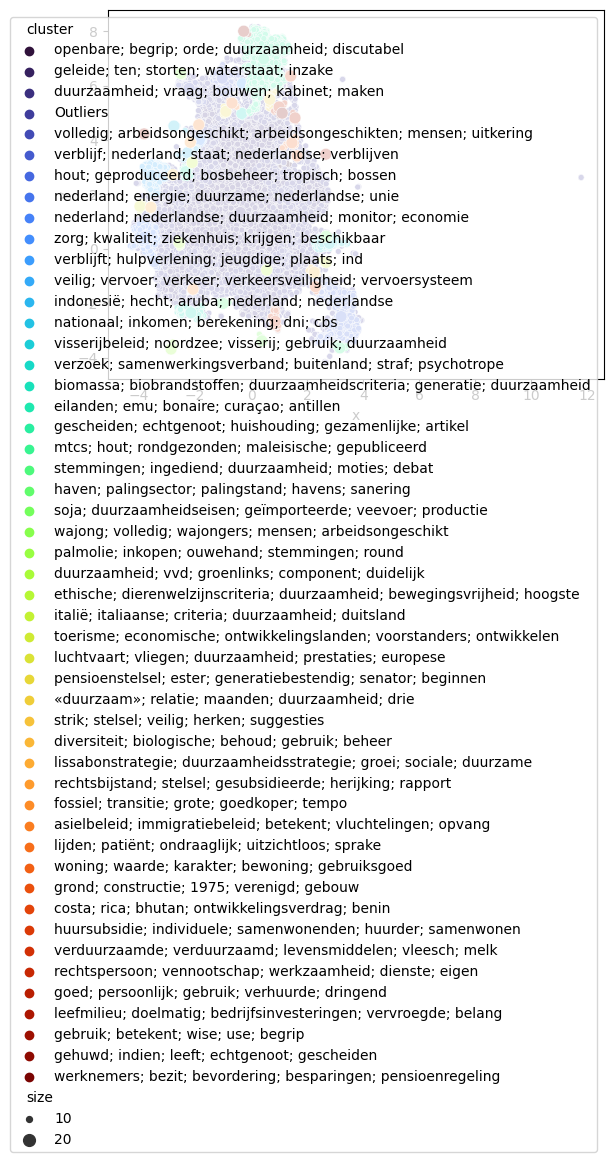

In [22]:
from tempo_embeddings.visualization.clusters import ClusterVisualizer

visualizer = ClusterVisualizer(clusters)
visualizer.visualize()

In [23]:
from tempo_embeddings.visualization.plotly import PlotlyVisualizer


visualizer = PlotlyVisualizer(*clusters)

visualizer.visualize(metadata_fields=corpus.metadata_fields())

### TODO: Refine sub-corpora

## Wizmap

In [24]:
%autoreload now

from tempo_embeddings.visualization.wizmap import WizmapVisualizer

port = 8000

if "wizmap_visualizer" in locals():
    # Cleanup previous run
    wizmap_visualizer.cleanup()


wizmap_visualizer = WizmapVisualizer(
    corpus, title=FILTER_TERMS[0], stopwords=list(stopwords)
)

wizmap_visualizer.visualize(port=port)

Start generating data list...
Start generating contours...
Start generating multi-level summaries...


26925it [00:00, 107662.22it/s]
100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Starting server on port 8000


<iframe
 srcdoc="<!DOCTYPE html><html lang="en"><head><meta charset="UTF-8" /><meta name="viewport" content="width=device-width, initial-scale=1.0" /><title>WizMap</title><style>html {font-size: 16px;-moz-osx-font-smoothing: grayscale;-webkit-font-smoothing: antialiased;text-rendering: optimizeLegibility;-webkit-text-size-adjust: 100%;-moz-text-size-adjust: 100%;scroll-behavior: smooth;}html, body {position: relative;width: 100%;height: 100%;overscroll-behavior: none;}body {margin: 0px;padding: 0px;box-sizing: border-box;font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen-Sans, Ubuntu, Cantarell, 'Helvetica Neue', sans-serif;color: hsl(0, 0%, 29%);font-size: 1em;font-weight: 400;line-height: 1.5;}*, ::after, ::before {box-sizing: inherit;}a {color: rgb(0, 100, 200);text-decoration: none;}a:hover {text-decoration: underline;}a:visited {color: rgb(0, 80, 160);}label {display: block;}input, select, textarea {font-family: inherit;font-size: inherit;-webkit-padding: 0 0;padding: 0;margin: 0 0 0 0;box-sizing: border-box;border: 1px solid #ccc;border-radius: 2px;}input:disabled {color: #ccc;}button {all: unset;outline: none;cursor: pointer;}</style><script defer src='data:text/javascript;base64,dmFyIHdpem1hcD1mdW5jdGlvbigpeyJ1c2Ugc3RyaWN0Ijt2YXIgSmY9T2JqZWN0LmRlZmluZVByb3BlcnR5O3ZhciBQZj0oZWksUSxhbik9PlEgaW4gZWk/SmYoZWksUSx7ZW51bWVyYWJsZTohMCxjb25maWd1cmFibGU6ITAsd3JpdGFibGU6ITAsdmFsdWU6YW59KTplaVtRXT1hbjt2YXIgbXQ9KGVpLFEsYW4pPT4oUGYoZWksdHlwZW9mIFEhPSJzeW1ib2wiP1ErIiI6USxhbiksYW4pO2Z1bmN0aW9uIGVpKCl7fWZ1bmN0aW9uIFEodCxsLGksZSxuKXt0Ll9fc3ZlbHRlX21ldGE9e2xvYzp7ZmlsZTpsLGxpbmU6aSxjb2x1bW46ZSxjaGFyOm59fX1mdW5jdGlvbiBhbih0KXtyZXR1cm4gdCgpfWZ1bmN0aW9uIGgwKCl7cmV0dXJuIE9iamVjdC5jcmVhdGUobnVsbCl9ZnVuY3Rpb24gb2UodCl7dC5mb3JFYWNoKGFuKX1mdW5jdGlvbiBwMCh0KXtyZXR1cm4gdHlwZW9mIHQ9PSJmdW5jdGlvbiJ9ZnVuY3Rpb24gYmQodCxsKXtyZXR1cm4gdCE9dD9sPT1sOnQhPT1sfHx0JiZ0eXBlb2YgdD09Im9iamVjdCJ8fHR5cGVvZiB0PT0iZnVuY3Rpb24ifWZ1bmN0aW9uIFlaKHQpe3JldHVybiBPYmplY3Qua2V5cyh0KS5sZW5ndGg9PT0wfWNvbnN0IHVjPXR5cGVvZiB3aW5kb3c8InUiP3dpbmRvdzp0eXBlb2YgZ2xvYmFsVGhpczwidSI/Z2xvYmFsVGhpczpnbG9iYWw7ZnVuY3Rpb24gWjAodCxsKXt0LmFwcGVuZENoaWxkKGwpfWZ1bmN0aW9uIFdvKHQsbCxpKXtjb25zdCBlPVJaKHQpO2lmKCFlLmdldEVsZW1lbnRCeUlkKGwpKXtjb25zdCBuPUQoInN0eWxlIik7bi5pZD1sLG4udGV4dENvbnRlbnQ9aSxIWihlLG4pfX1mdW5jdGlvbiBSWih0KXtpZighdClyZXR1cm4gZG9jdW1lbnQ7Y29uc3QgbD10LmdldFJvb3ROb2RlP3QuZ2V0Um9vdE5vZGUoKTp0Lm93bmVyRG9jdW1lbnQ7cmV0dXJuIGwmJmwuaG9zdD9sOnQub3duZXJEb2N1bWVudH1mdW5jdGlvbiBIWih0LGwpe3JldHVybiBaMCh0LmhlYWR8fHQsbCksbC5zaGVldH1mdW5jdGlvbiBUWih0LGwsaSl7dC5pbnNlcnRCZWZvcmUobCxpfHxudWxsKX1mdW5jdGlvbiBHMCh0KXt0LnBhcmVudE5vZGUmJnQucGFyZW50Tm9kZS5yZW1vdmVDaGlsZCh0KX1mdW5jdGlvbiBrWih0LGwpe2ZvcihsZXQgaT0wO2k8dC5sZW5ndGg7aSs9MSl0W2ldJiZ0W2ldLmQobCl9ZnVuY3Rpb24gRCh0KXtyZXR1cm4gZG9jdW1lbnQuY3JlYXRlRWxlbWVudCh0KX1mdW5jdGlvbiBjYyh0KXtyZXR1cm4gZG9jdW1lbnQuY3JlYXRlRWxlbWVudE5TKCJodHRwOi8vd3d3LnczLm9yZy8yMDAwL3N2ZyIsdCl9ZnVuY3Rpb24gc2kodCl7cmV0dXJuIGRvY3VtZW50LmNyZWF0ZVRleHROb2RlKHQpfWZ1bmN0aW9uIE50KCl7cmV0dXJuIHNpKCIgIil9ZnVuY3Rpb24gd1oodCxsLGksZSl7cmV0dXJuIHQuYWRkRXZlbnRMaXN0ZW5lcihsLGksZSksKCk9PnQucmVtb3ZlRXZlbnRMaXN0ZW5lcihsLGksZSl9ZnVuY3Rpb24gTVoodCxsLGkpe2k9PW51bGw/dC5yZW1vdmVBdHRyaWJ1dGUobCk6dC5nZXRBdHRyaWJ1dGUobCkhPT1pJiZ0LnNldEF0dHJpYnV0ZShsLGkpfWZ1bmN0aW9uIHZaKHQpe3JldHVybiBBcnJheS5mcm9tKHQuY2hpbGROb2Rlcyl9ZnVuY3Rpb24gbWQodCxsKXt0LnZhbHVlPWw9PW51bGw/IiI6bH1mdW5jdGlvbiBtbCh0LGwsaSl7dC5jbGFzc0xpc3RbaT8iYWRkIjoicmVtb3ZlIl0obCl9ZnVuY3Rpb24gSloodCxsLHtidWJibGVzOmk9ITEsY2FuY2VsYWJsZTplPSExfT17fSl7Y29uc3Qgbj1kb2N1bWVudC5jcmVhdGVFdmVudCgiQ3VzdG9tRXZlbnQiKTtyZXR1cm4gbi5pbml0Q3VzdG9tRXZlbnQodCxpLGUsbCksbn1sZXQgc3M7ZnVuY3Rpb24gb3ModCl7c3M9dH1mdW5jdGlvbiBQWigpe2lmKCFzcyl0aHJvdyBuZXcgRXJyb3IoIkZ1bmN0aW9uIGNhbGxlZCBvdXRzaWRlIGNvbXBvbmVudCBpbml0aWFsaXphdGlvbiIpO3JldHVybiBzc31mdW5jdGlvbiByZCh0KXtQWigpLiQkLm9uX21vdW50LnB1c2godCl9Y29uc3QgaGQ9W10sYm49W107bGV0IHBkPVtdO2NvbnN0IFgwPVtdLE5aPVByb21pc2UucmVzb2x2ZSgpO2xldCBhYz0hMTtmdW5jdGlvbiB6Wigpe2FjfHwoYWM9ITAsTloudGhlbih5MCkpfWZ1bmN0aW9uIGJjKHQpe3

In [25]:
if False:
    wizmap_visualizer.cleanup()

127.0.0.1 - - [01/Nov/2023 11:59:43] "GET /grid.json HTTP/1.1" 200 -
127.0.0.1 - - [01/Nov/2023 11:59:43] "GET /data.ndjson HTTP/1.1" 200 -
